# LangGraph

LangGraph is a framework that allows you to define execution flows. It is designed for building agentic systems.

In [1]:
from typing import TypedDict, Literal, Annotated

import langgraph
from langgraph.types import Command
from langgraph.graph import END, START, StateGraph

## State

The **state** is the object that moves through the entire graph. It provides the input information to the nodes and passes the information from the current node to the next one.

The schema of the `State` must be provided when defining of the `langgraph.graph.StateGraph`. Supported ways to define a schema include: `typing.TypedDict`, `dataclasses.dataclass`, or `pydantic.BaseModel`.

Check more cases in the [State](langgraph/state.ipynb)

---

Consider a case in which the state is defined as a `dataclass`. The following cell creates a graph that processes a `State` dataclass instance and increments the `inp` attribute. 

In [13]:
from dataclasses import dataclass


@dataclass
class State:
    inp: int


def my_node(state: State):
    print(state)
    state.inp += 1
    return state


builder = StateGraph(State)
builder.add_node("my", my_node)

builder.add_edge(START, "my")
builder.add_edge("my", END)

graph = builder.compile()

The following cell invokes the graph for `State(inp=4)`.

In [15]:
graph.invoke(State(inp=4))

State(inp=4)


{'inp': 5}

## Reducing

If two graph flows join at the same node and both return a value, there will be a conflict. You must specify a strategy for merging the outputs using a **reducer function**.

THe **reducer function** can be defined as metatdata of the `typing.Annotated` for the specific attribute. This function will be applied if the outputs from those nodes need to be processed in some way. The most common way is to use the `operator.add` function, which is equivalent to simply apply the `+` operator.

Check more in [Reducing](langgraph/reducing.ipynb) page.

---

The following cell shows the definition of the state that applies `operator.add` when there are two outputs in a node.

In [5]:
import operator
from typing import Annotated


class State(TypedDict):
    out: Annotated[str, operator.add]

The next code creates a graph with two parallel nodes, each attempt to update the `out` attribute of the state.

In [6]:
def node_a(state: State) -> State:
    return State(out="A output")


def node_b(state: State) -> State:
    return State(out="B output")


builder = StateGraph(State)

builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_edge(START, "a")
builder.add_edge(START, "b")

graph = builder.compile()
graph.invoke(State(out="value"))

{'out': 'valueA outputB output'}

As a result, the outputs of the different nodes were simply concatenated.

## Composition

There is a set of tricks that will enable you to create the graph you want. You can set up:

- Some nodes can invoke several subsequnt nodes.
- You can define conditions to select the nodes will be executed next in runtime.
- There are some pre-built components with special properties.
- You can include a subgraphs in your graphs.

Check more in [Composition](langgraph/composition.ipynb) page.

## Conditional edges

Conditional edges allow you to define a graph that will go one way or another depending on the conditions.

You can define the conditional node using:

- Adding the node that returns `langgraph.types.Command` with `goto` specifying the name of the next node.
- Adding the edge with `add_conditional_edge` method of the graph builder.

Find out more in the [Conditional edges](langgraph/conditional_edges.ipynb).

---

The following cell defines the conditional node that directs the execution to either the `END` or `"a"` node, depending on the corresponding value of the `state["goto"]`.

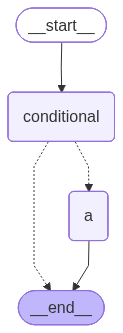

In [ ]:
class State(TypedDict):
    goto: Literal["a", "__end__"]


def node_a(state: State) -> State:
    print("a node is invoked")
    return state


def conditional_node(state: State) -> Command[Literal["a", "__end__"]]:
    return Command(update=state, goto=state["goto"])


graph = (
    StateGraph(State)
    .add_node("conditional", conditional_node)
    .add_node("a", node_a)

    .add_edge(START, "conditional")
    .add_edge("a", END)
    .compile()
)
graph

The following cell invokes the graph with to be executed with the `"a"` node.

In [28]:
_ = graph.invoke(State(goto="a"))

a node is invoked


And alternatively routing directly to the `__end__`.

In [30]:
_ = graph.invoke(State(goto="__end__"))

We always receive messages from random nodes, but always only two of them.

## Memory

You can save the state between the graph infocations. During graph compilation, you must pass a `checkpointer` object. This object will keep the output of the previous invocation bounded to **thread**. The thread is specified by the `configurable.thread_id` field of the `configuration` argument. 

---

The following cell builds and compiles the graph. Note that the checkpointer passes an `InMemorySaver` instance, which stores the information about the outputs of the last invocation in memory. Each time the graph is invoked, a random number is added to the input.

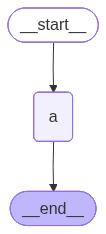

In [103]:
import operator
from random import randint
from typing import Annotated
from langgraph.checkpoint.memory import InMemorySaver

in_memory_saver = InMemorySaver()


class State(TypedDict):
    value: Annotated[list[int], operator.add]


def node_a(state: State) -> State:
    return State(value=[randint(0, 10)])


graph = (
    StateGraph(State)
    .add_node("a", node_a)

    .add_edge(START, "a")
    .add_edge("a", END)

    .compile(checkpointer=in_memory_saver)
)
graph

Invoking such a graph requires specifying the thread because memory is bounded by the thread.

In [104]:
graph.invoke(
    State(value=[]),
    {"configurable": {"thread_id": 1}}
)

{'value': [9]}

The second invocation with the same specified thread contains the output of the previous invocation, plus the new generated number:

In [105]:
graph.invoke(
    State(value=[]),
    {"configurable": {"thread_id": 1}}
)

{'value': [9, 2]}

The invocation in the other thread yelds a new number:

In [106]:
graph.invoke(
    State(value=[]),
    {"configurable": {"thread_id": 2}}
)

{'value': [8]}

### Get state

You can obtain a state of the graph compiled with the checkpointer using `get_state` method.

---

The following cell creates a graph with a checkpointer and invokes it.

In [10]:
from langgraph.checkpoint.memory import InMemorySaver


class State(TypedDict):
    val: int


graph = (
    StateGraph(State)
    .add_edge(START, END)
    .compile(checkpointer=InMemorySaver())
)


config = {"configurable": {"thread_id": 1}}
graph.invoke(State(val=10), config=config)

{'val': 10}

The following cell shows the output of the `get_config` method.

In [11]:
graph.get_state(config)

StateSnapshot(values={'val': 10}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e40d4-6375-62d3-8000-9b4cbf309622'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-12-28T16:50:11.222370+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e40d4-6371-6248-bfff-01bb70305306'}}, tasks=(), interrupts=())

## Interrupt

Use `langgraph.types.interrupt` to interrupt the execution of the graph. This function stops the graph's execution and returns the dictionary that containing information associated with interuption under key `__interrupt__`.

---

The following cell defines the one-node graph that interrupts during the excution, allowing you to the kind of output produced.

In [5]:
from langgraph.types import interrupt


class State(TypedDict):
    pass


def node_a(state: State) -> State:
    interrupt("Interupted info")
    return state


graph = (
    StateGraph(State)
    .add_node("a", node_a)
    .add_edge(START, "a")
    .add_edge("a", END)
    .compile()
)
graph.invoke(State())

{'__interrupt__': [Interrupt(value='Interupted info', id='60925f781639672ec3c0fb49ea1639ba')]}

### Continue execution

The main purpose of the `interrupt` is `langgraph` is to build human in the loop applications: in which user can provide additional information to the LLM based application during the application execution.

To do that you have too:

- Add memory to your graph.
- The `interrupt` invocation returns to the graph information provided from the flow outside the graph.
- To resume the execution, invoke graph again with `langgraph.types.Command` providing additional information via the `resume` argument.

---

The following cell defines the graph in which a single node calls `interupt` and publishes the result to the `State`.

In [13]:
from langgraph.checkpoint.memory import InMemorySaver


class State(TypedDict):
    message_from_user: str | None


def node(state: State) -> State:
    ans = interrupt("Expecting input")
    return State(message_from_user=ans)


graph = (
    StateGraph(State)
    .add_node("a", node)
    .add_edge(START, "a")
    .add_edge("a", END)
    .compile(checkpointer=InMemorySaver())
)

The `config` of the graph invocation is important here as it specifies which thread was interrupted.

In [14]:
config = {"configurable": {"thread_id": 1}}

ans = graph.invoke(
    State(message_from_user=None),
    config=config
)
ans

{'message_from_user': None,
 '__interrupt__': [Interrupt(value='Expecting input', id='2581629b0859baae999813442c5e719d')]}

The graph is interrupted. The next cell shows the how to resume the execution and provide the information to the graph.

In [ ]:
graph.invoke(
    Command(resume="This is input from user"),
    config=config
)

{'message_from_user': 'This is input from user'}

## State streaming

You can stream the state of the graph by using the `stream` method and it's async version ,`astream`e, instead of the `invoke` method. This will return an interator that will return either the current state of the graph or it's updates, depending on the stream mode:

- The `stream_mode="updates"` (default) returns only updates of the graph.
- The `stream_mode="values"` returns entire state at each step.

---

Consider an example in which a graph adds random values to a list until it reaches a specified length.

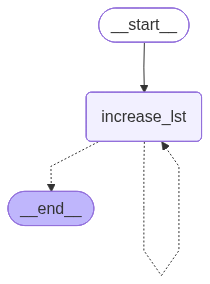

In [21]:
import random
import operator


class State(TypedDict):
    lst: Annotated[list[str], operator.add]


def increase_lst(
    state: State
) -> langgraph.types.Command[Literal["increase_lst", END]]:
    if len(state["lst"]) < 3:
        return langgraph.types.Command(
            update={"lst": [random.choice([
                "hello", "world", "this", "is", "me"
            ])]},
            goto="increase_lst"
        )
    return langgraph.types.Command(goto=END)


graph = (
    StateGraph(State)
    .add_node("increase_lst", increase_lst)
    .add_edge(START, "increase_lst")
    .compile()
)

graph

Invoking of the graph works just as expected: the output contains a list with the specified number of elements.

In [24]:
graph.invoke(State(lst=[]))

{'lst': ['world', 'hello', 'this']}

If the `stream` method is invoked, an iterator is created:

In [25]:
next(iter(graph.stream(State(lst=[]))))

{'increase_lst': {'lst': ['this']}}

The following cell iterates through all the outputs of the graph:

In [26]:
for s in graph.stream(State(lst=[])):
    print(s["increase_lst"])

{'lst': ['this']}
{'lst': ['is']}
{'lst': ['me']}
None


Next code shows the `stream_mode="values"` case:

In [33]:
for s in graph.stream(State(lst=[]), stream_mode="values"):
    print(s)

{'lst': []}
{'lst': ['world']}
{'lst': ['world', 'is']}
{'lst': ['world', 'is', 'me']}


We get all the corresponding states at each step.

## Events streaming

Using the grpaph's `astream_events` method, you can execute graph events as langgraph accesses them.

---

The following cell creates a simple graph and shows some attributes of the events returned from the corresponding iterator.

In [14]:
class State(TypedDict):
    pass


def node(state: State):
    pass


graph = (
    StateGraph(State)
    .add_node("node", node)
    .add_edge(START, "node")
    .add_edge("node", END)
    .compile()
)

async for event in graph.astream_events(State()):
    print(event["event"], event["name"])

on_chain_start LangGraph
on_chain_start node
on_chain_stream node
on_chain_end node
on_chain_stream LangGraph
on_chain_end LangGraph


### Model stream

One of the most useful events is `on_chat_model_stream`. This event type retains the tokens returned by the call to the model - each token represents a different Langgraph event.

---

The following cell creates a graph which only node invokes the model with the given message.

In [21]:
from langchain_ollama import ChatOllama


class State(TypedDict):
    question: str


model = ChatOllama(
    model="llama3.1"
)


def node(state: State):
    model.invoke(state["question"])


graph = (
    StateGraph(State)
    .add_node("node", node)
    .add_edge(START, "node")
    .add_edge("node", END)
    .compile()
)

The following cell iterates over `on_chat_model_stream` events, and shows the content of the messages.

In [37]:
input_state = State(question="What is the capital of France")
async for event in graph.astream_events(input_state):
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content)

The
 capital
 of
 France
 is
 Paris
.




## Studio

The studio is a graphical IDE that allows you to monitor the execution of your graphs.

To use studio you have to setup the [langgraph application](https://docs.langchain.com/langsmith/application-structure#python) and run there `langgraph dev` command.

**Note** install the `langgraph-cli[inmem]` package to lauch the Langgraph application from your virtual environment.

---

The following cell setsup the simplest possible langgraph application.

In [1]:
!rm -rf /tmp/studio && mkdir /tmp/studio

In [2]:
%%writefile /tmp/studio/my_graph.py
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    message: str
    value: int

def node(state: State):
    return state

state_graph = (
    StateGraph(State)
    .add_node("a", node)
    .add_edge(START, "a")
    .add_edge("a", END)
)

Writing /tmp/studio/my_graph.py


By settings `LANGSMITH_TRACING=false` environment variable you can turn off the tracking with langsmith.

In [3]:
%%writefile /tmp/studio/.env
LANGSMITH_TRACING=false

Writing /tmp/studio/.env


The `langgraph.json` determines the langgraph application.

In [4]:
%%writefile /tmp/studio/langgraph.json
{
    "dependencies": [
        "langgraph"
    ],
    "graphs": {
        "my_agent": "./my_graph.py:state_graph"
    },
    "env": ".env"
}

Writing /tmp/studio/langgraph.json


Run your langgraph application with commands:

```bash
cd /tmp/studio
langgraph dev
```

You can access the UI of the studio from the LangSmith site typically: `https://smith.langchain.com/studio/?baseUrl=<local address of your application>`.